In [14]:
import shap
import lime
import lime.lime_tabular
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix


In [15]:
# Charger le modèle (remplace 'modele.joblib' par ton fichier réel)
pipeline = joblib.load("models/joblib/RandomForest-roc_auc.joblib")

data = pd.read_csv('../data/processed/merged_data_2019_2022.csv')

X = data.drop(columns=['grav'])
y = data['grav']

E:\Telechargements\Datascientest\Git_GitHub\repos\Projet_Accidentologie\venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
E:\Telechargements\Datascientest\Git_GitHub\repos\Projet_Accidentologie\venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
E:\Telechargements\Datascientest\Git_GitHub\repos\Projet_Accidentologie\venv\Lib\site-packages\sklearn\base

In [16]:
columns_to_drop_at_loading = ["an", "an_nais", "tpc"]
X.drop(columns=columns_to_drop_at_loading, inplace= True)

In [17]:
sample_size = 50000
X_sample = X.sample(n=sample_size, random_state=42)
y_sample = y.loc[X_sample.index]

In [18]:
print(X_sample.columns)

Index(['place', 'catu', 'sexe', 'trajet', 'locp', 'actp', 'catv', 'obs',
       'obsm', 'manv', 'jour', 'mois', 'lum', 'agg', 'int', 'atm', 'col',
       'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'vma',
       'nb_v', 'nb_u', 'imply_cycle_edp', 'imply_2rm', 'imply_vl', 'imply_pl',
       'age', 'jour_semaine', 'hr', 'reg', 'has_ceinture', 'has_gants',
       'has_casque', 'has_airbag', 'has_gilet', 'has_de', 'choc_avant',
       'choc_arriere', 'choc_gauche', 'choc_droit'],
      dtype='object')


In [19]:
# Transformer l'échantillon avec le préprocesseur du pipeline
X_sample_transformed = pipeline.named_steps['preprocessor'].transform(X_sample)

# Extraire uniquement le modèle du pipeline
model = pipeline.named_steps['classifier']
print(f"Nombre d'arbres dans le modèle : {model.n_estimators}")



Nombre d'arbres dans le modèle : 300


In [20]:
# Récupérer la liste des noms des features avant transformation
feature_names_before = list(X_sample.columns)
feature_names_after = pipeline.named_steps['preprocessor'].get_feature_names_out(feature_names_before)

# Convertir `X_sample_transformed` en DataFrame avec les nouveaux noms de colonnes
X_sample_transformed_df = pd.DataFrame(X_sample_transformed, columns=feature_names_after, index=X_sample.index)

# Vérification
print(X_sample_transformed_df.head())

        num__jour  num__mois  num__agg  num__vma  num__nb_v  num__nb_u  \
161536   0.433333   1.000000       1.0  0.384615   0.041667   0.078947   
134814   0.533333   0.181818       1.0  0.384615   0.041667   0.026316   
409695   0.166667   0.727273       1.0  0.384615   0.041667   0.026316   
400278   0.900000   0.727273       1.0  0.384615   0.041667   0.026316   
420627   0.066667   0.636364       0.0  0.538462   0.041667   0.026316   

        num__imply_cycle_edp  num__imply_2rm  num__imply_vl  num__imply_pl  \
161536                   0.0             0.0            1.0            0.0   
134814                   0.0             0.0            1.0            0.0   
409695                   0.0             0.0            1.0            0.0   
400278                   0.0             1.0            0.0            0.0   
420627                   0.0             0.0            0.0            1.0   

        ...  cat__reg_Nouvelle-Aquitaine  cat__reg_Nouvelle-Calédonie  \
161536  ...  

In [21]:
# Créer un Explainer SHAP
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_sample_transformed_df, approximate= True)

In [22]:
print(type(shap_values))
print(len(shap_values))

<class 'numpy.ndarray'>
50000


In [23]:
print(shap_values.shape)

(50000, 120, 2)


In [24]:
import numpy as np

# Calculer l'importance absolue moyenne des SHAP values
shap_importance = np.abs(shap_values[:, :, 1]).mean(axis=0)

# Trier les features par importance décroissante
sorted_features = np.argsort(-shap_importance)
sorted_feature_names = X_sample_transformed_df.columns[sorted_features]

# Afficher l'ordre des features selon SHAP
print("Ordre des features par importance SHAP :")
for feature in sorted_feature_names:
    print(feature)



Ordre des features par importance SHAP :
cat__reg_Ile-de-France
num__has_ceinture
num__agg
num__vma
num__imply_2rm
num__age
cat__catv_vl
num__has_casque
cat__catv_2rm
num__nb_u
cat__obsm_aucun
cat__obs_aucun
cat__actp_sans_objet
num__nb_v
cat__locp_sans
cat__trajet_personnelle
num__choc_arriere
num__imply_cycle_edp
num__choc_avant
num__imply_vl
cat__situ_particuliere
num__hr
cat__obsm_pieton
num__imply_pl
cat__obsm_vehicule
cat__situ_normale
num__jour
cat__place_conducteur
cat__catr_route_secondaire
cat__place_pieton
cat__trajet_professionnelle
cat__plan_courbe
cat__catr_route_principale
cat__int_aucun
cat__catu_pieton
num__mois
cat__plan_rectiligne
cat__obs_structurel
cat__catu_en_vehicule
cat__manv_ligne_droite
cat__int_simple
cat__obs_naturel
cat__catv_cycle_edp
cat__circ_simple
cat__lum_jour
cat__col_autres
num__has_gants
cat__circ_complexe
cat__manv_changement_dir
num__choc_droit
cat__catv_pl
cat__col_deux_vl
cat__lum_nocturne
cat__sexe_masculin
cat__sexe_feminin
num__choc_gauche


Classe 1:


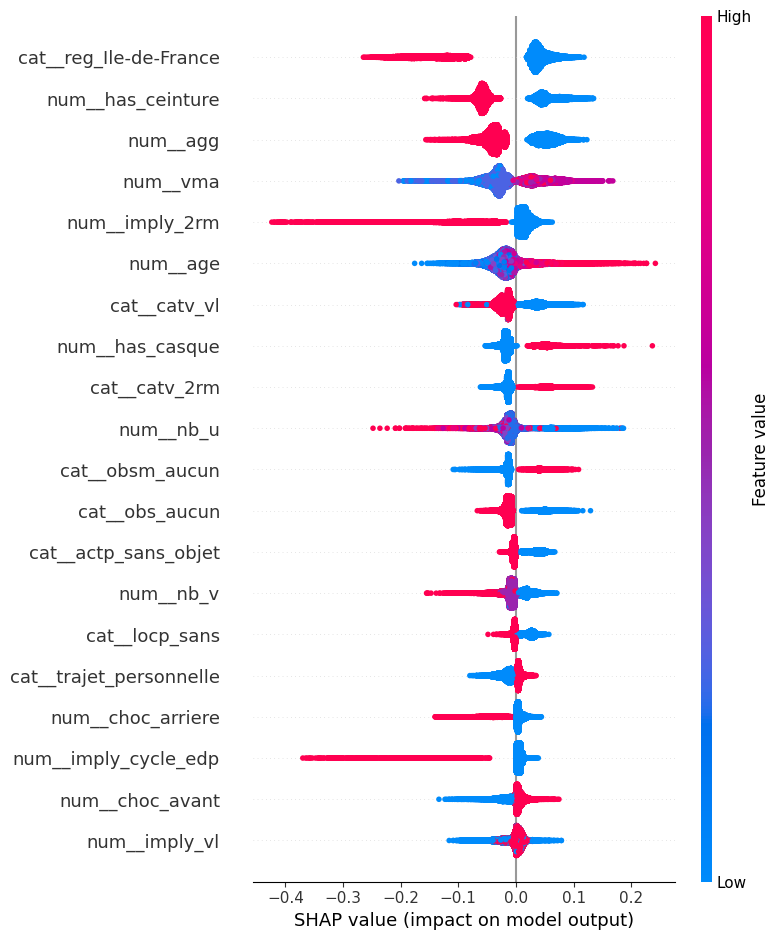

In [25]:

shap_values_class_1 = shap_values[:, :, 1]  # Classe 1
print("Classe 1:")
shap.summary_plot(shap_values_class_1, X_sample_transformed_df, max_display= 20)

E:\Telechargements\Datascientest\Git_GitHub\repos\Projet_Accidentologie\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


L'individu sélectionné est mal classifié. Le vrai label est 0.


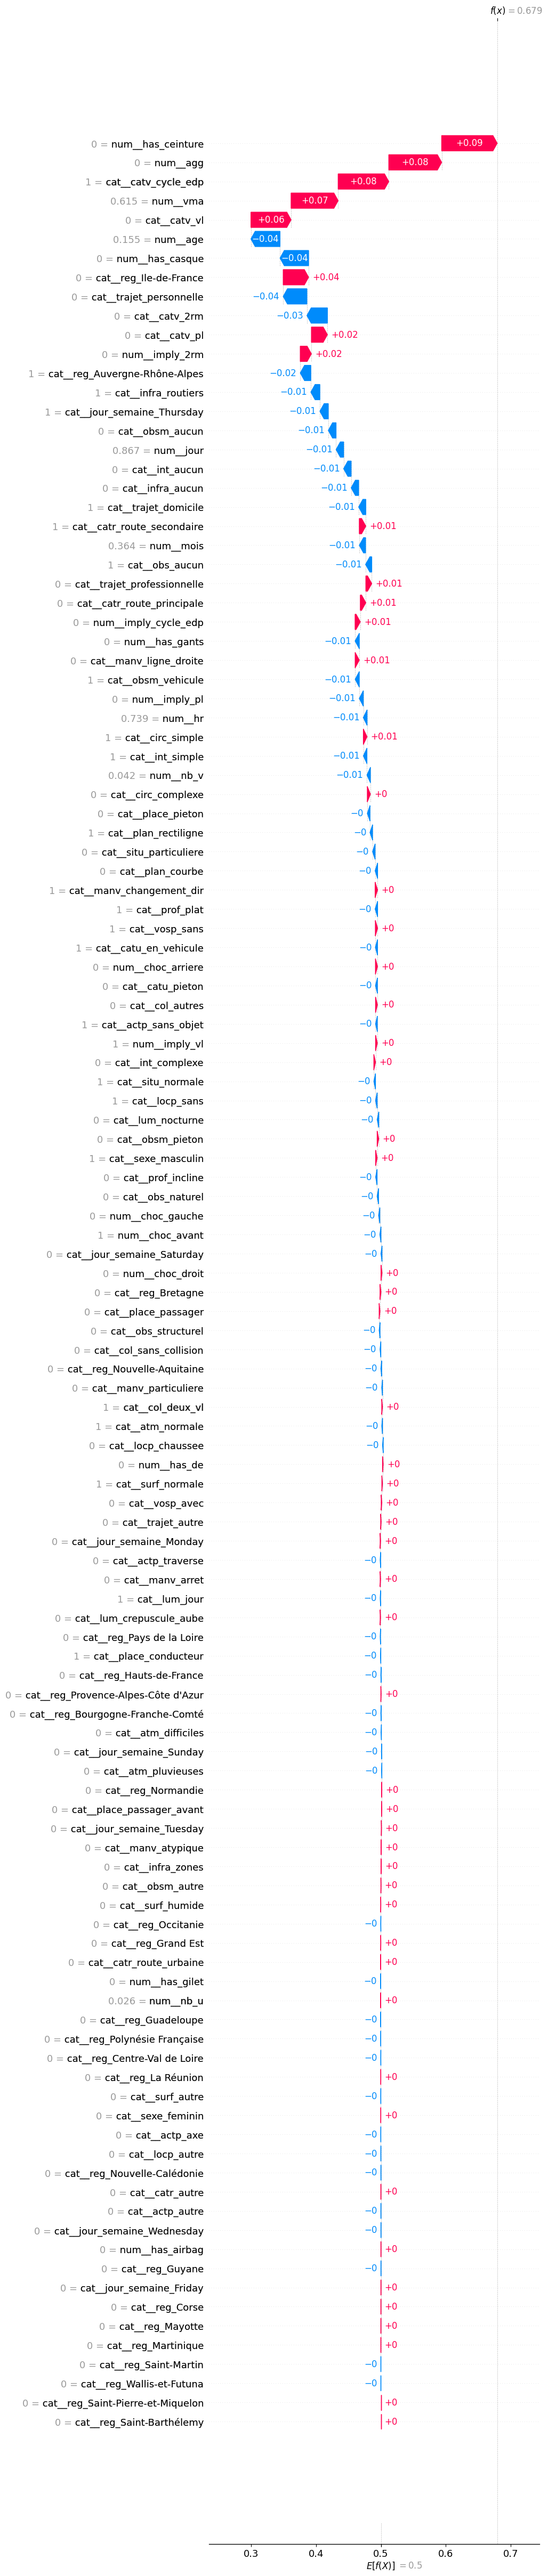

In [26]:
# Filtrer les indices où le modèle a prédit la classe 1
class_1_indices = np.where(model.predict(X_sample_transformed_df) == 1)[0]

# Vérifier s'il y a des individus classifiés en classe 1
if len(class_1_indices) > 0:
    # Sélectionner un individu au hasard parmi ceux classifiés en classe 1
    idx = np.random.choice(class_1_indices)

    # Vérifier si la prédiction est correcte
    is_correct = y_sample.iloc[idx] == 1  # Comparer la prédiction avec le label réel

    if is_correct:
        print(f"L'individu sélectionné est correctement classifié en classe 1.")
    else:
        print(f"L'individu sélectionné est mal classifié. Le vrai label est {y_sample.iloc[idx]}.")

    # Sélectionner les K features avec les plus grandes SHAP values absolues
    K = 10  # Nombre de features à afficher
    top_k_indices = np.argsort(-np.abs(shap_values_class_1[idx, :]))[:K]

    # Afficher le Force Plot uniquement avec ces features
    #shap.initjs() 
    shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_class_1[idx, :], 
        base_values=explainer.expected_value[1], 
        data=X_sample_transformed_df.iloc[idx, :]
        ),
    max_display=141
    )

else:
    print("Aucun individu n'a été classifié en classe 1.")
